# Solution to Assignment 1 - Vehicle stock in China

## Preparation: Packages and data imports

Start by importing the necessary packages:

In [1]:
#Importing necessary packages
#In this notebook, we will need pandas, numpy, and matplotlib.pyplot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

In [2]:
import sys
import os
 
# getting the name of the directory where the this file is present.
current = os.path.dirname(os.path.realpath('this'))
 
# Getting the parent directory name where the current directory is present.
parent = os.path.dirname(current)
#make the UA path
MFA_module_path = parent + '/MFA_modules'
#append path to options to import from
sys.path.append(MFA_module_path)

#We also need to import the class DynamicStockModel from the package dynamic_stock_model
from dynamic_stock_model import DynamicStockModel

Then import the data into a Dataframe using the pandas read_excel function (check the documentation to find out which arguments to use) and clean it.

In [3]:
# Extracting data from the source file into a panda Dataframe
file = "Warm_up_14_data.xls"
# This file should be placed in the same directory as this notebook (on the JupyterHub server)

# We read the data and store it in a Dataframe called "data", using the read_excel() panda function
data = pd.read_excel(file, sheet_name = 'CarStockData', usecols='D:P', skiprows=1)
# sheet_name, usecols and skiprows help us select the right data
data.drop(index=[0,1],inplace=True)
# We don't need to have the unit and dependency in the dataframe
data.reset_index(drop=True, inplace=True)
# We re-start the index counter to be at 0
# This is just to replace all the void values in "data" by 0, which makes things easier
data.fillna(0, inplace=True)

In [4]:
data.head()

,Time,Population,Inflow,Outflow,Stock Change,Stock,cars per 1000 people,Kilometrage per vehicle,Fuel efficiency,Carbon intensity,Total km driven,Total gasoline consumend,Total direct CO2 emissions
0,1950,544951.0,1157.864047,0,0,0,0.0,27200.0,9.07,2.4,0,0,0
1,1951,555606.0,3085.651022,0,0,0,0.0,27200.0,9.07,2.4,0,0,0
2,1952,566261.0,1314.644583,0,0,0,0.0,27200.0,9.07,2.4,0,0,0
3,1953,576916.0,4843.545514,0,0,0,0.0,27200.0,9.07,2.4,0,0,0
4,1954,587571.0,3575.745174,0,0,0,0.0,27200.0,9.07,2.4,0,0,0


Create two Dataframes from data:
 - historic_data with values up to 2008
 - future_data with values for 2009 and after


In [5]:
historic_data = data[data.Time < 2009]
future_data = data[data.Time >= 2009]

## Inflow-driven model

Calculate outflows, stock change and stock for historic data, using an inflow-driven model:

In [6]:
def inflow_driven_model(inflows_t:list[float], time:list[float], tau:float, sigma:float) ->tuple[np.array]:
    '''
    Function to conduct all inflow driven calculations based on the inflows in time.

    Arguments:
    inflows_t: list (or other ordered iterable) specifying the inflows in time
    time: list (or other ordered iterable) specifying the time - same length as inflows!
    tau: mean lifetime for the goods entering the stock
    sigma: standard deviation of the mean lifetime of goods
    '''
    t = len(time)
    if t != len(inflows_t):
        raise ValueError(f'inflows and time need to be of same length, but have length {len(inflows_t)} and {t}.')
    # create empty arrays for all entities we want
    stock_tc = np.zeros((t,t))
    outflows_tc = np.zeros((t,t))
    stock_change_t = np.zeros((t))
    
    demolition_look_up = [sts.norm.cdf(age, tau, sigma)-sts.norm.cdf(age-1, tau, sigma) for age in range(t)]
    demolition_look_up[0] = sts.norm.cdf(0, tau, sigma)-sts.norm.cdf(-np.inf, tau, sigma)

    for i_t, year_t in enumerate(time):
        # take inflows for this year
        inflows = inflows_t[i_t]
        # diagonal of the stock_tc matrix is equal to that year
        stock_tc[i_t,i_t] = inflows
        # diagonal of the outflows is the risk of demolition up to age 0
        outflows_tc[i_t, i_t] = inflows*demolition_look_up[0]
        # stock_change are the total inflows minus total outflows
        outflows = sum(outflows_tc[i_t,:])
        stock_change_t[i_t] = inflows - outflows
        # iterate over all cohorts up until the currect one
        for i_c, year_c in enumerate(time[:i_t+1]):
            age = year_t-year_c+1
            if i_t < t-1: # define outflows for the next year for each cohort (for all but the last year)
                outflows_tc[i_t+1, i_c] = demolition_look_up[age]*inflows_t[i_c]
            if  i_c < i_t: # for all past cohorts we need to update the stock
                stock_tc[i_t, i_c] = stock_tc[i_t-1, i_c] -outflows_tc[i_t, i_c]
            else: # for the current cohort, we just subtract the outflows
                stock_tc[i_t, i_c] -= outflows_tc[i_t, i_c]
    return stock_tc, outflows_tc, stock_change_t

lifetime = 15
std = 5
time = historic_data['Time']
inflows_t = historic_data['Inflow']

stock_tc, outflows_tc, stock_change_t = inflow_driven_model(inflows_t, time, lifetime, std)

In [7]:
# We first define the paramters lifetime function that we are going to use
lifetime = 15
std_dev = 5

# We then create a DynamicStockModel

DSM =  DynamicStockModel(t=historic_data['Time'],
                         i=historic_data['Inflow'],
                         lt={'Type': 'Normal', 
                             'Mean': np.array([lifetime]),
                             'StdDev': np.array([std_dev]) 
                             }
                            )
# It is necessary to convert the lifetime and st_dev to arrays 
# in order to respect the specifications of the class

# We can perform a dimension check
print(DSM.dimension_check())                  

inflow_dsm_t = DSM.i

# Calculating the stock by cohort
DSM.compute_s_c_inflow_driven()
stock_dsm_tc = DSM.s_c

# Calculating the outflows by cohort
DSM.compute_o_c_from_s_c()
outflow_dsm_tc = DSM.o_c

# Calculating the total stock
#stock = np.sum(s_c, axis = 1)
stock_dsm_t   = DSM.compute_stock_total()

# Calculating the total outflow
outflow_dsm_t = DSM.compute_outflow_total()

<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 59 years.<br>Inflow vector is present with 59 years.<br>Total stock is not present.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15].<br>


(0.0, 7774272.701074441)

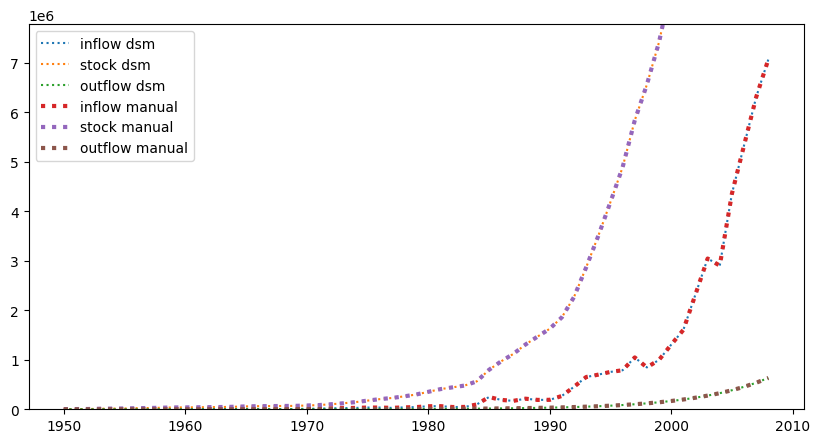

In [8]:
# lets plot inflow, stock and outflow
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(historic_data['Time'], inflow_dsm_t,':',lw =1.5, label='inflow dsm')
ax.plot(historic_data['Time'], stock_dsm_t,':',lw =1.5, label='stock dsm')
ax.plot(historic_data['Time'], outflow_dsm_t,':',lw =1.5, label='outflow dsm')
ax.plot(historic_data['Time'], inflows_t,':',lw =3, label='inflow manual')
ax.plot(historic_data['Time'], np.sum(stock_tc, axis = 1),':',lw =3, label='stock manual')
ax.plot(historic_data['Time'], np.sum(outflows_tc, axis = 1),':',lw =3, label='outflow manual')
ax.legend()
ax.set_ylim(0, 1.1 * max(inflow_dsm_t))

In [9]:
# Add results to DataFrame
historic_data.loc[:,'Stock'] = DSM.s

## Stock-driven model

Calculate stock change, outflows and inflows for future data, using a stock-driven model. You need to run the stock-driven model for all years, combining historic stock data from the inflow-driven model, and future stock data from population and car ownership projections.

In [10]:
def stock_driven_model(stock_t:list[float], time:list[float], tau:float, sigma:float) ->tuple[np.array]:
    '''
    Function to conduct all stock driven calculations based on the stock in time.

    Arguments:
    stock_t: list (or other ordered iterable) specifying the stock in time
    time: list (or other ordered iterable) specifying the time - same length as stock!
    tau: mean lifetime for the goods entering the stock
    sigma: standard deviation of the mean lifetime of goods
    '''
    t = len(time)
    if t != len(stock_t):
        raise ValueError(f'stock and time need to be of same length, but have length {len(stock_t)} and {t}.')
    # create empty arrays for all entities we want
    stock_tc = np.zeros((t,t))
    outflows_tc = np.zeros((t,t))
    inflows_t = np.zeros((t))
    stock_change_t = np.zeros((t))
    
    demolition_look_up = [sts.norm.cdf(age, tau, sigma)-sts.norm.cdf(age-1, tau, sigma) for age in range(t)]
    demolition_look_up[0] = sts.norm.cdf(0, tau, sigma)

    for i_t, year_t in enumerate(time):
        if i_t >0:
            stock_change_t[i_t] = stock_t[i_t] - stock_t[i_t-1]
        else: # first year
            stock_change_t[i_t] = stock_t[i_t]
        outflows = sum(outflows_tc[i_t,:])
        # inflows are outflows plus stock change, plus the expected outflows in the same year
        inflows_t[i_t] = (outflows + stock_change_t[i_t])/(1-demolition_look_up[0])
        outflows_tc[i_t, i_t] = inflows_t[i_t]*demolition_look_up[0]
        stock_tc[i_t,i_t] = inflows_t[i_t]
        # iterate over all cohorts up until the currect one
        for i_c, year_c in enumerate(time[:i_t+1]):
            age = year_t-year_c+1
            if i_t < t-1: # define outflows for the next year for each cohort (for all but the last year)
                outflows_tc[i_t+1, i_c] = demolition_look_up[age]*inflows_t[i_c]
            if  i_c < i_t: # for all past cohorts we need to update the stock
                stock_tc[i_t, i_c] = stock_tc[i_t-1, i_c] -outflows_tc[i_t, i_c]
            else: # for the current cohort, we just subtract the outflows
                stock_tc[i_t, i_c] -= outflows_tc[i_t, i_c]
    return stock_tc, outflows_tc, stock_change_t, inflows_t

future_data.loc[:,'Stock'] =  future_data['cars per 1000 people'] * future_data['Population']

# We combine historic and future stock data
data.loc[:,'Stock'] = pd.concat([historic_data['Stock'],future_data['Stock']])

stock_manual_tc, outflows_manual_tc, stock_change_manual_t, inflows_manual_t= stock_driven_model(data['Stock'], data['Time'], 15, 5)

In [11]:
# Stock driven model for future scenario

# Creation of the stock vector 
# Input from future scenario for population and car ownership
future_data.loc[:,'Stock'] =  future_data['cars per 1000 people'] * future_data['Population']

# We combine historic and future stock data
data.loc[:,'Stock'] = pd.concat([historic_data['Stock'],future_data['Stock']])


# Creation of the new DSM, with time, stock and lifetime as inputs
DSMf = DynamicStockModel(t=data['Time'],
                         s=data['Stock'],
                         lt={'Type': 'Normal', 
                             'Mean': np.array([lifetime]),
                             'StdDev': np.array([std_dev]) 
                             }
                            )

#print(DSMf.dimension_check())                  
#DSMf.dimension_check()     
DSMf.compute_stock_driven_model() 
DSMf.compute_outflow_total()
DSMf.compute_stock_total()
inflow_dsm_t = DSMf.i
outflow_dsm_t = DSMf.o
stock_dsm_tc = DSMf.s_c

# Checking mass balance
#print(DSMf.check_stock_balance())  


## Final calculations

Perform the calculations for distance driven, fuel consumption and CO2 emissions

In [12]:
# The number of kilometers driven by car is a function of time: 
# the order in the multiplication matters!
total_km_driven_tc = np.dot(np.diag(data['Kilometrage per vehicle']), stock_dsm_tc)
total_km_driven_t  = np.sum(total_km_driven_tc, axis=1)

# The fuel efficiency is given in L/100 km, it is then necessary to divide by 100
# and further divide by 10^6 to get the results in ML
# The fuel efficiency is a function of the cohort and not time
total_gasoline_t  = np.dot(total_km_driven_tc, data['Fuel efficiency'] / 10**8)
# It is further necessary to divide by 1000 to get the results in Mt CO2
total_CO2_t       = total_gasoline_t * data['Carbon intensity'] / 1000

## Plot the results

Plot the results of the model for inflows and outflows, stock change, stock, total distance driven, total fuel consumption, and total CO2 emissions

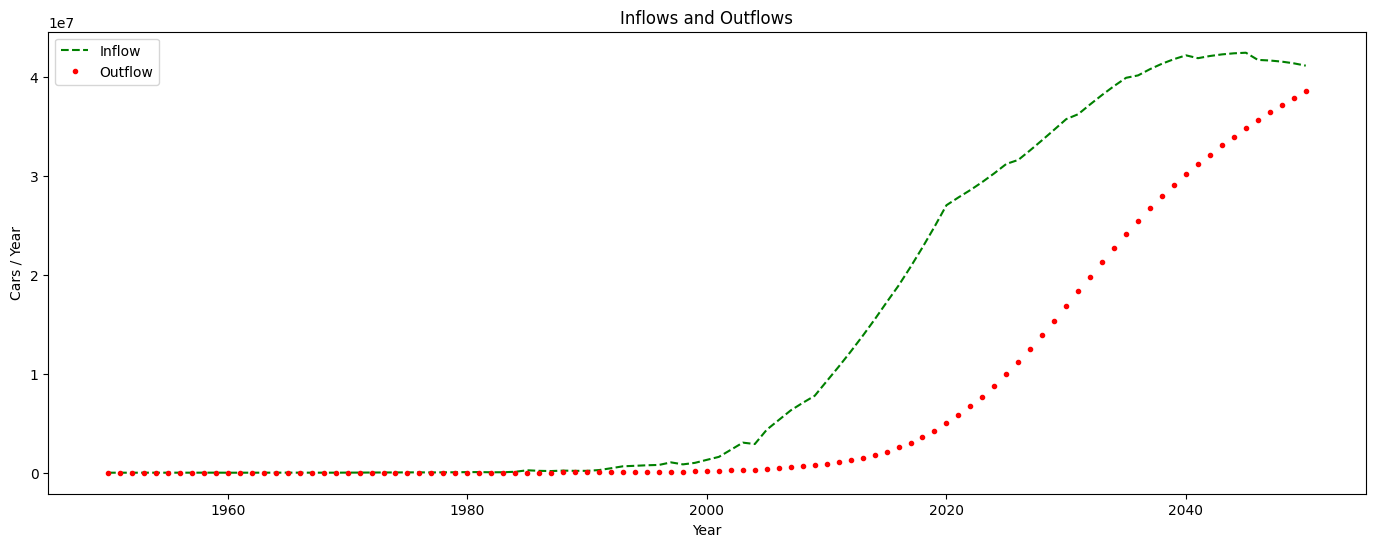

In [13]:
# Inflows and Outflows
plt.figure(figsize=(17, 6))
plt.plot(DSMf.t, DSMf.i, 'g--', label='Inflow')
plt.plot(DSMf.t, DSMf.o, 'r.', label='Outflow')
plt.title('Inflows and Outflows')
plt.xlabel('Year')
plt.ylabel('Cars / Year')
plt.legend(loc='best')
#plt.savefig('Results/in_outflows_total')

Text(0, 0.5, 'Cars / Year')

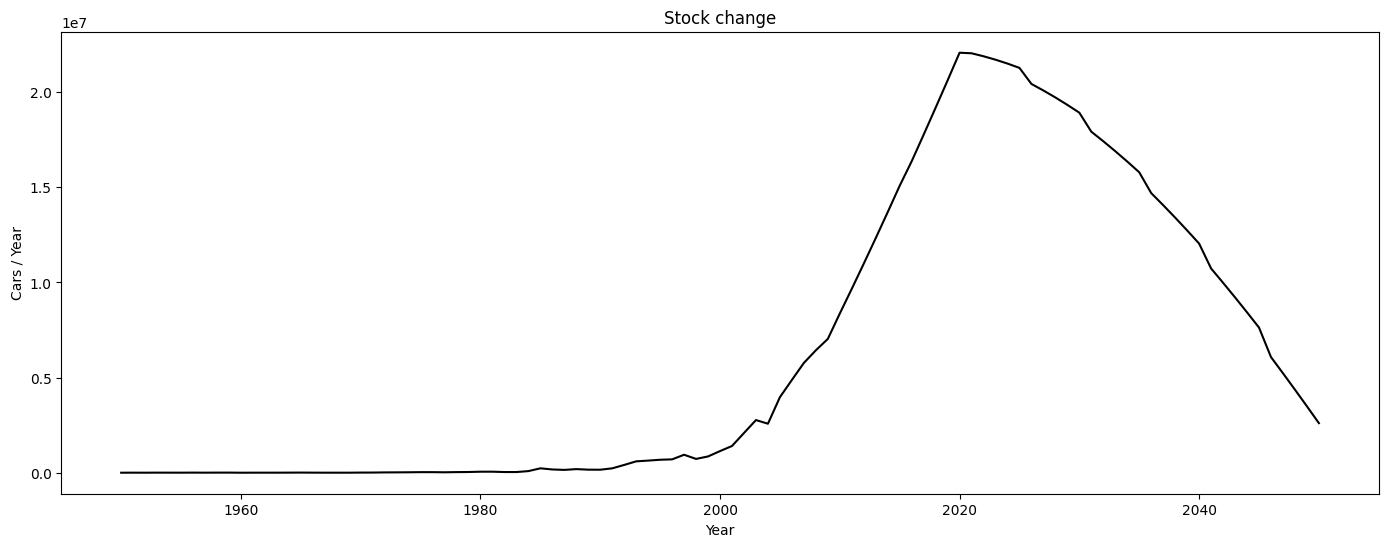

In [14]:
# Stock change
plt.figure(figsize=(17, 6))
plt.plot(DSMf.t, DSMf.i - DSMf.o, 'black')
plt.title('Stock change')
plt.xlabel('Year')
plt.ylabel('Cars / Year')
#plt.savefig('Results/ds_only_total')

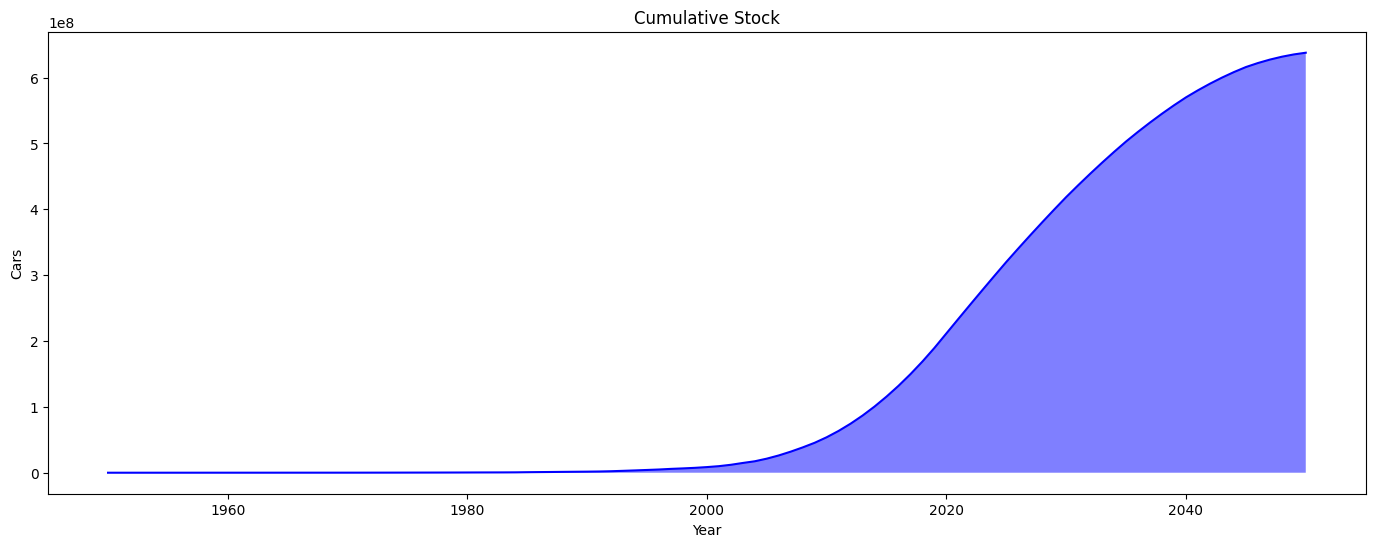

In [15]:
# Total Stock
plt.figure(figsize=(17, 6))
plt.plot(DSMf.t, DSMf.s, 'blue')
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('Cars')
plt.fill_between(DSMf.t, DSMf.s, facecolor='blue', alpha=0.5)
#plt.savefig('Results/stock_total')

Text(0, 0.5, 'km / Year')

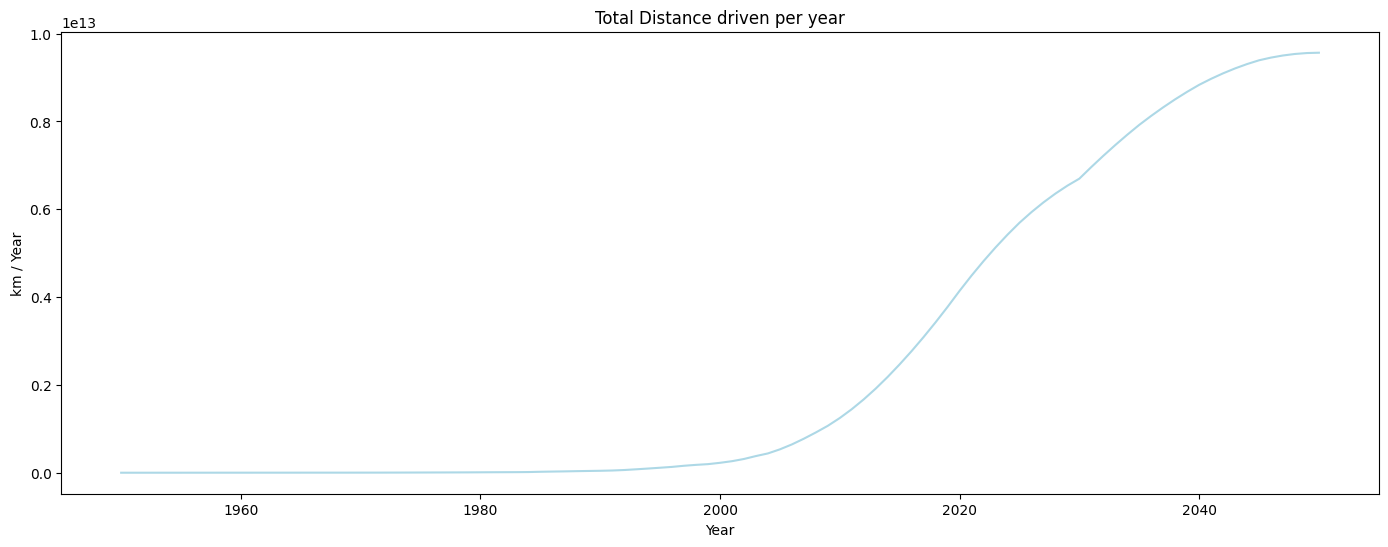

In [16]:
# Total Distance driven
plt.figure(figsize=(17, 6))
plt.plot(DSMf.t, total_km_driven_t, 'lightblue')
plt.title('Total Distance driven per year')
plt.xlabel('Year')
plt.ylabel('km / Year')

Text(0, 0.5, 'ML / Year')

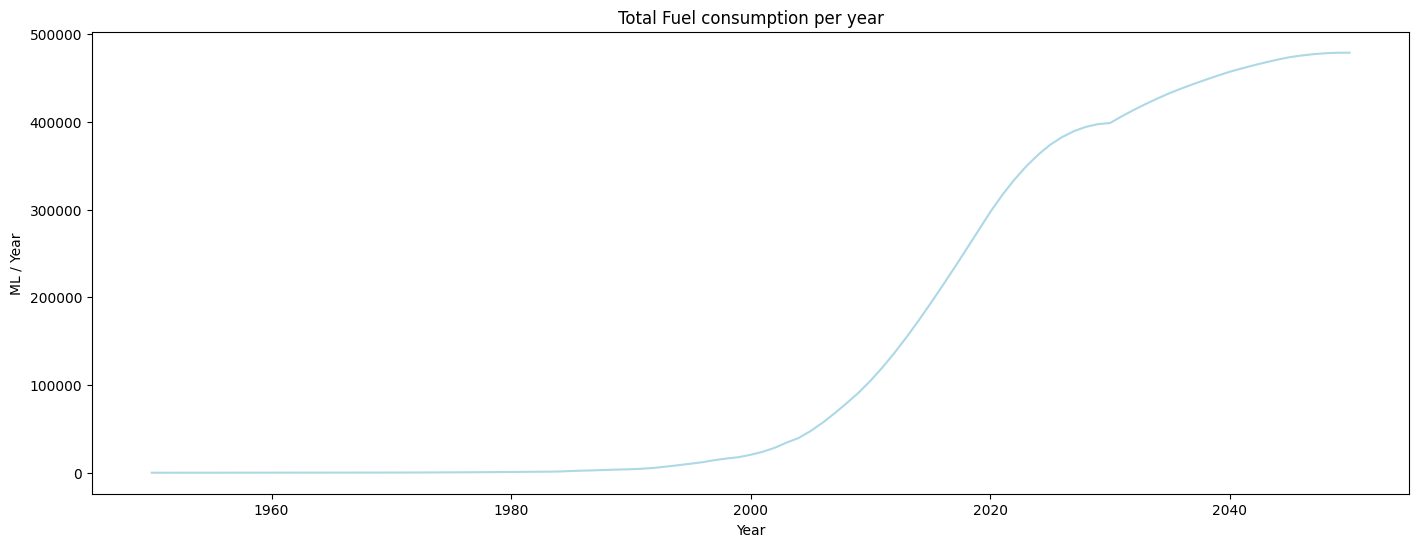

In [17]:
# TotalFuel consumption
plt.figure(figsize=(17, 6))
plt.plot(DSMf.t, total_gasoline_t, 'lightblue')
plt.title('Total Fuel consumption per year')
plt.xlabel('Year')
plt.ylabel('ML / Year')

Text(0, 0.5, 'Mt CO2 / Year')

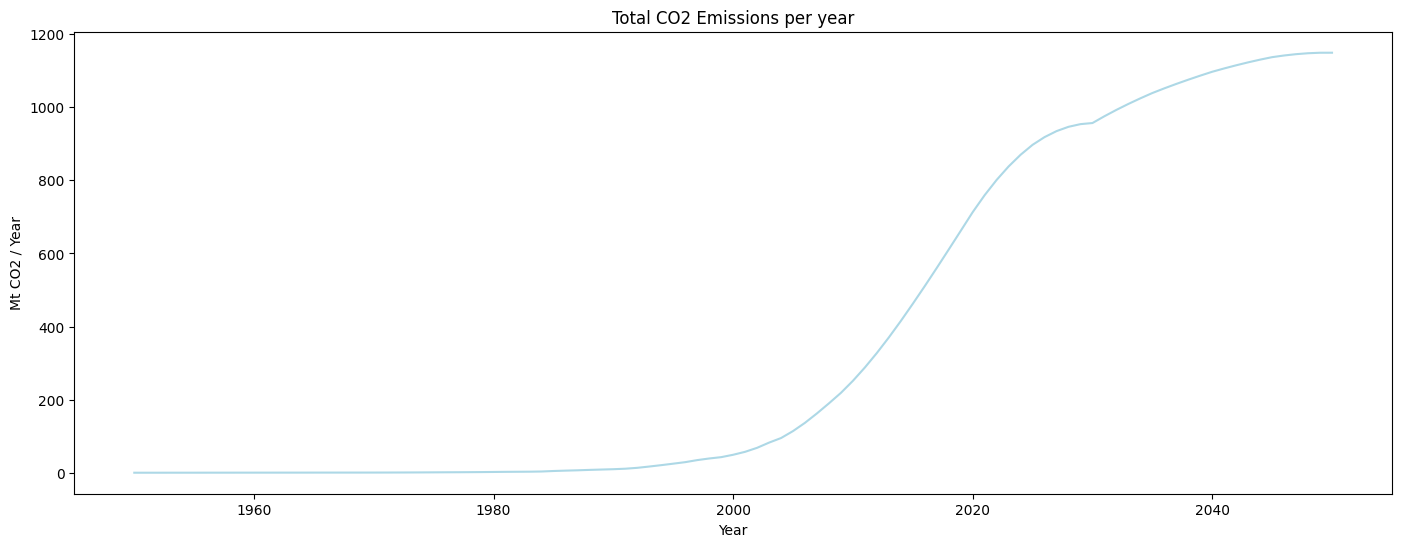

In [18]:
# Total CO2 Emissions
plt.figure(figsize=(17, 6))
plt.plot(DSMf.t, total_CO2_t, 'lightblue')
plt.title('Total CO2 Emissions per year')
plt.xlabel('Year')
plt.ylabel('Mt CO2 / Year')

We can also plot the results in a single figure, and export it:

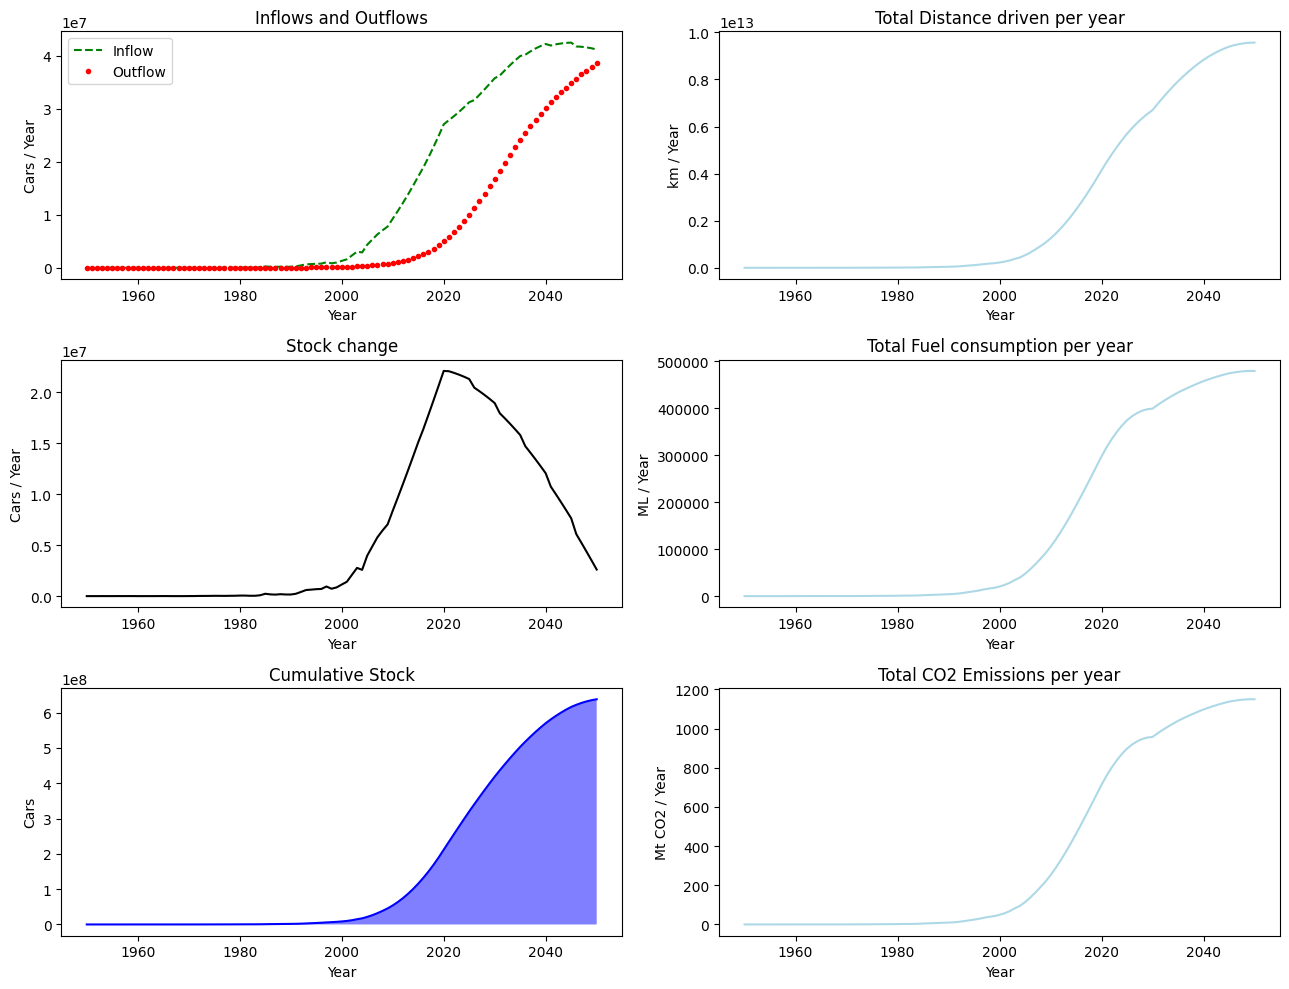

In [19]:
# Plotting the results
fig = plt.figure(figsize=(13, 10))

# Inflows and Outflows
ax1 = fig.add_subplot(321)
ax1.plot(DSMf.t, DSMf.i, 'g--', label='Inflow')
ax1.plot(DSMf.t, DSMf.o, 'r.', label='Outflow')
ax1.set(title='Inflows and Outflows',
        xlabel='Year',
        ylabel='Cars / Year')
ax1.legend(loc='best')

# Stock change
plt.subplot(323)
plt.plot(DSMf.t, DSMf.i - DSMf.o, 'black')
plt.title('Stock change')
plt.xlabel('Year')
plt.ylabel('Cars / Year')

# Total Stock
ax = plt.subplot(325)
plt.plot(DSMf.t, DSMf.s, 'blue')
plt.title('Cumulative Stock')
plt.xlabel('Year')
plt.ylabel('Cars')
ax.fill_between(DSMf.t, DSMf.s, facecolor='blue', alpha=0.5)

# Total Distance driven
plt.subplot(322)
plt.plot(DSMf.t, total_km_driven_t, 'lightblue')
plt.title('Total Distance driven per year')
plt.xlabel('Year')
plt.ylabel('km / Year')

# TotalFuel consumption
plt.subplot(324)
plt.plot(DSMf.t, total_gasoline_t, 'lightblue')
plt.title('Total Fuel consumption per year')
plt.xlabel('Year')
plt.ylabel('ML / Year')

# Total CO2 Emissions
plt.subplot(326)
plt.plot(DSMf.t, total_CO2_t, 'lightblue')
plt.title('Total CO2 Emissions per year')
plt.xlabel('Year')
plt.ylabel('Mt CO2 / Year')

# Exporting the plots
plt.tight_layout()
#plt.savefig('results_python.png')
plt.show()

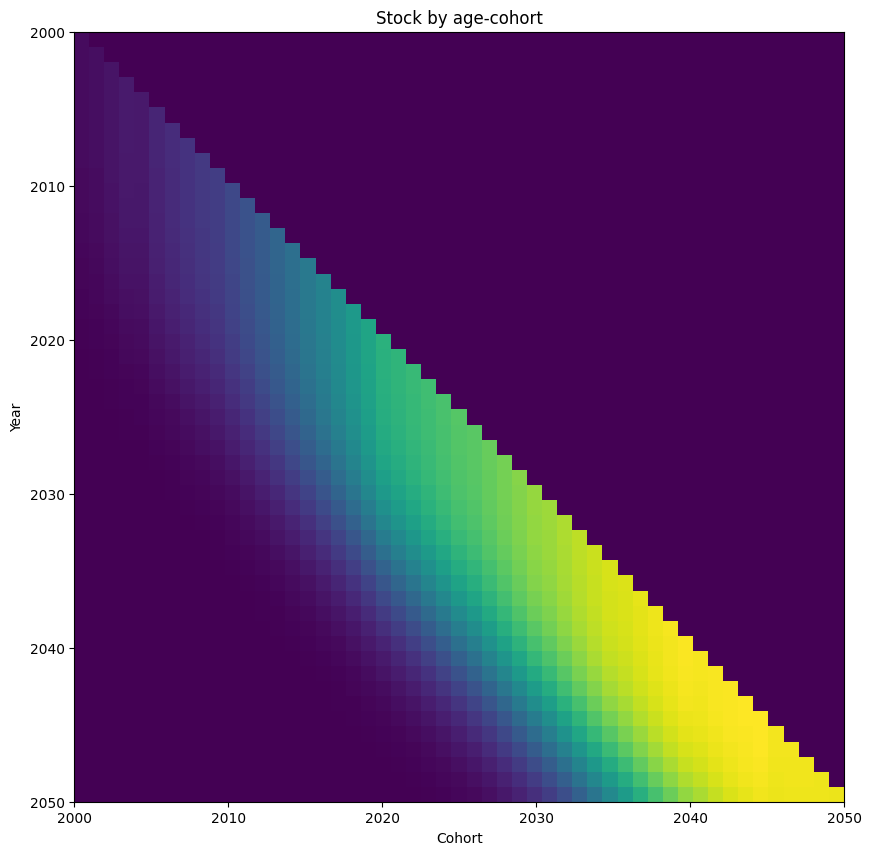

In [20]:
#Heat Map

plt.figure(figsize=(10, 10))
plt.imshow(DSMf.s_c[50:,50:], 
           extent=[DSMf.t[50], DSMf.t[len(DSMf.t)-1], DSMf.t[len(DSMf.t)-1], DSMf.t[50]],
           interpolation='nearest'
           #           ,cmap='nipy_spectral'
           )
plt.title('Stock by age-cohort')
plt.xlabel('Cohort')
plt.ylabel('Year')

#plt.savefig('Heat map.png')
plt.show()

## Exports the results

Export the results back to the Excel file (if you want to)

In [21]:
data['Total km driven'] = total_km_driven_t
data['Total gasoline consumend'] = total_gasoline_t
data['Total direct CO2 emissions'] = total_CO2_t
data['Stock Change'] = DSMf.i - DSMf.o
data.Outflow = DSMf.o
data.Inflow = DSMf.i

In [25]:
data.to_excel('results.xlsx')

In [23]:
data

,Time,Population,Inflow,Outflow,Stock Change,Stock,cars per 1000 people,Kilometrage per vehicle,Fuel efficiency,Carbon intensity,Total km driven,Total gasoline consumend,Total direct CO2 emissions
0,1950,544951.0,1.157864e+03,1.562998e+00,1.156301e+03,1.156301e+03,0.000000,27200.0,9.07,2.4,3.145139e+07,2.852641,0.006846
1,1951,555606.0,3.085651e+03,5.560809e+00,3.080090e+03,4.236391e+03,0.000000,27200.0,9.07,2.4,1.152298e+08,10.451347,0.025083
2,1952,566261.0,1.314645e+03,7.932091e+00,1.306712e+03,5.543104e+03,0.000000,27200.0,9.07,2.4,1.507724e+08,13.675059,0.032820
3,1953,576916.0,4.843546e+03,1.871591e+01,4.824830e+03,1.036793e+04,0.000000,27200.0,9.07,2.4,2.820078e+08,25.578106,0.061387
4,1954,587571.0,3.575745e+03,3.095181e+01,3.544793e+03,1.391273e+04,0.000000,27200.0,9.07,2.4,3.784262e+08,34.323253,0.082376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2046,1435640.2,4.176050e+07,3.568187e+07,6.078631e+06,6.219748e+08,433.238601,15200.0,5.00,2.4,9.454016e+12,475744.141308,1141.785939
97,2047,1430991.4,4.169986e+07,3.647066e+07,5.229196e+06,6.272039e+08,438.300291,15150.0,5.00,2.4,9.502140e+12,477252.438060,1145.405851
98,2048,1426342.6,4.158591e+07,3.721875e+07,4.367161e+06,6.315711e+08,442.790609,15100.0,5.00,2.4,9.536724e+12,478311.142215,1147.946741
99,2049,1421693.8,4.141385e+07,3.792106e+07,3.492791e+06,6.350639e+08,446.695272,15050.0,5.00,2.4,9.557712e+12,478873.459816,1149.296304
